# EMG Gesture Classification: Comparative Analysis of Deep Learning Architecture

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:

# Load the dataset from a CSV file.
df = pd.read_csv("data/processed/EMG-data.csv")


# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
def print_color(text: str, color: str) -> None:
    """
    Prints text in specified ANSI color for better readability in notebooks.
    
    Args:
        text (str): Text to be printed
        color (str): Color name ('red', 'green', 'yellow', 'blue', 'magenta')
    """
    colors = {
        "red": "\033[91m",
        "green": "\033[92m",
        "yellow": "\033[93m",
        "blue": "\033[94m",
        "magenta": "\033[95m"
    }
    print(f"{colors.get(color, '')}{text}\033[0m")


In [4]:

def plot_emg_channels(data: np.ndarray, title: str = "EMG Signals", 
                      sample_idx: int = 0, channels: int = 8) -> None:
    """
    Plot EMG channels from a window of data.
    
    Args:
        data (np.ndarray): EMG data array with shape (windows, time_steps, channels)
        title (str): Title for the plot
        sample_idx (int): Index of the window to plot
        channels (int): Number of EMG channels
    """
    plt.figure(figsize=(12, 16))
    window_data = data[sample_idx]
    for i in range(channels):
        plt.subplot(channels, 1, i + 1)
        plt.plot(window_data[:, i])
        plt.title(f'{title}, Channel {i+1}')
        plt.xlabel('Time Step')
        plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()


In [5]:

def create_sliding_windows(data: np.ndarray, labels: np.ndarray, 
                          window_size: int, step_size: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Create sliding windows from EMG data for time series analysis.
    
    Args:
        data (np.ndarray): EMG data as a numpy array
        labels (np.ndarray): Corresponding labels
        window_size (int): Size of each window
        step_size (int): Step size between consecutive windows
    
    Returns:
        Tuple[np.ndarray, np.ndarray]: Windowed data and corresponding labels
    """
    X_list = []
    y_list = []
    
    for i in range(0, len(data) - window_size + 1, step_size):
        X_list.append(data[i:i + window_size])
        # Use the most frequent label in the window
        y_list.append(labels[i + window_size // 2])  # Take the middle point's label
    
    return np.array(X_list), np.array(y_list)


In [6]:
# Adjust gesture labels to be zero-indexed
df['gesture'] = df['gesture'] - 1

# Count number of unique gestures
num_classes = df['gesture'].nunique()

# Explore dataset
print_color("Head of DataFrame:", "green")
print(df.head())

print_color("Shape of DataFrame:", "green")
print(df.shape)

# Check for null values
null_count = df.isnull().sum()
print_color("Null values in each column:", "yellow")
print(null_count)

# Dataset properties
print_color("Unique gestures (zero-indexed):", "blue")
print(sorted(df["gesture"].unique()))

print_color("Unique subjects:", "blue")
print(sorted(df["subject"].unique()))



Head of DataFrame:
   Channel_1  Channel_2  Channel_3  Channel_4  Channel_5  Channel_6  \
0         -4        -11        -39        -18         -1          1   
1          2         12          5          9          1          0   
2         29         27         24         19        -46        -14   
3        -33        -28         -9         44         63         13   
4         39        -36        -50         22          8          0   

   Channel_7  Channel_8  subject  repetition  gesture  
0         -2         -1        1           1        0  
1        -14        -20        1           1        0  
2        -19         21        1           1        0  
3         19         15        1           1        0  
4        -17         -3        1           1        0  
Shape of DataFrame:
(664666, 11)
Null values in each column:
Channel_1     0
Channel_2     0
Channel_3     0
Channel_4     0
Channel_5     0
Channel_6     0
Channel_7     0
Channel_8     0
subject       0
repetition   

Shape of X_tensor:
torch.Size([13284, 100, 8])
Shape of y_tensor:
torch.Size([13284])
Data statistics in X_tensor:
Mean: -1.4992
Standard Deviation: 22.8343
Max value: 127.0000
Min value: -128.0000


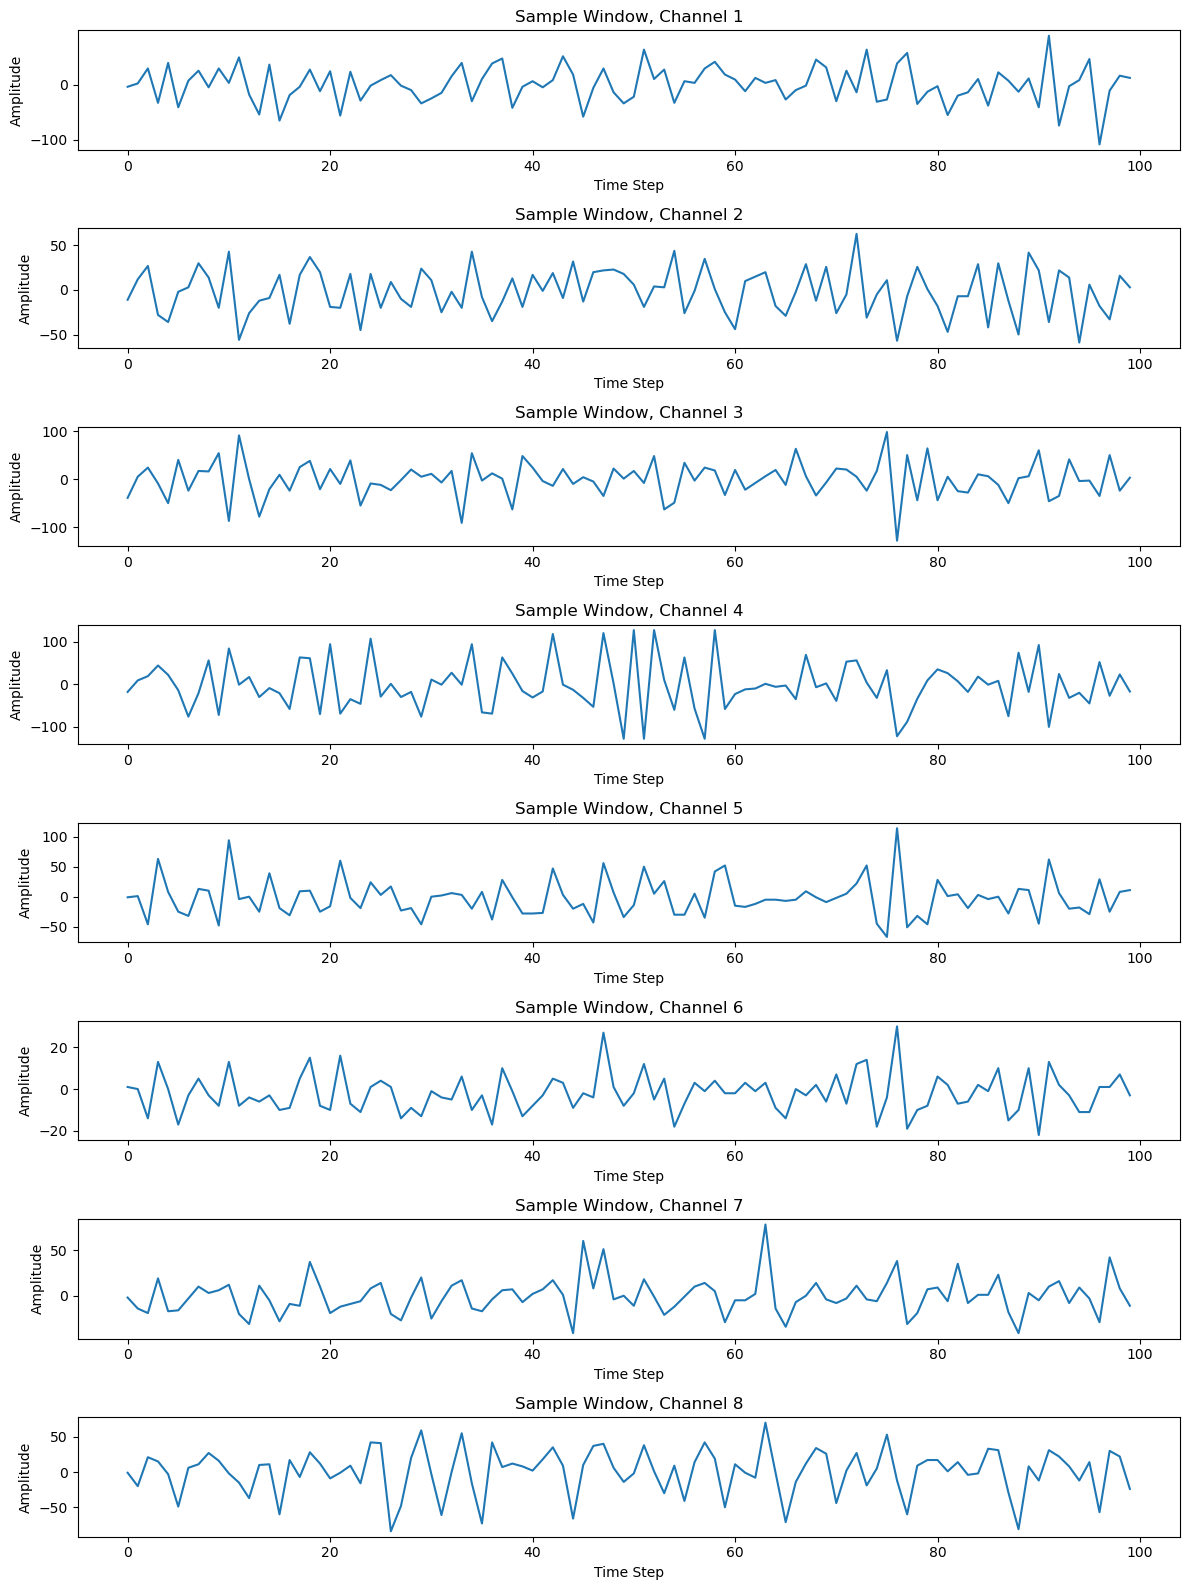

In [7]:
# Set window size and step size for slicing the data
WINDOW_SIZE = 100  # Number of samples per window
STEP_SIZE = 50     # Interval between consecutive windows

# Extract channel data
channel_cols = [f'Channel_{i}' for i in range(1, 9)]
X_list = []
y_list = []

# Group the data by gesture and create windows
for gesture_id in sorted(df["gesture"].unique()):
    gesture_df = df[df["gesture"] == gesture_id]
    gesture_data = gesture_df[channel_cols].values
    
    # Generate overlapping windows of data
    for start_idx in range(0, len(gesture_data) - WINDOW_SIZE + 1, STEP_SIZE):
        window_data = gesture_data[start_idx:start_idx + WINDOW_SIZE]
        X_list.append(window_data)
        y_list.append(gesture_id)

# Convert lists to NumPy arrays
X_array = np.array(X_list)
y_array = np.array(y_list)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_array, dtype=torch.float32)
y_tensor = torch.tensor(y_array, dtype=torch.long)

# Move tensors to device
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)


# Display shapes and stats
print_color("Shape of X_tensor:", "red")
print(X_tensor.shape)
print_color("Shape of y_tensor:", "red")
print(y_tensor.shape)

# Print data statistics
print_color("Data statistics in X_tensor:", "green")
print(f"Mean: {torch.mean(X_tensor).item():.4f}")
print(f"Standard Deviation: {torch.std(X_tensor).item():.4f}")
print(f"Max value: {torch.max(X_tensor).item():.4f}")
print(f"Min value: {torch.min(X_tensor).item():.4f}")

X_numpy = X_tensor.cpu().numpy()

# Plot a sample window
plot_emg_channels(X_numpy, title="Sample Window", sample_idx=0)


Data splitting

In [8]:
# Split data into training, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(
    X_tensor.cpu().numpy(),
    y_tensor.cpu().numpy(),
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y_tensor.cpu().numpy()  # Ensure class balance in splits
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, 
    test_size=0.5, 
    random_state=RANDOM_SEED,
    stratify=y_temp  # Maintain class balance
)

# Convert back to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Output the shapes of the datasets
print("Dataset splits:")
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Verify class distribution in splits
print("\nClass distribution in training set:")
for c in range(num_classes):
    print(f"Class {c}: {torch.sum(y_train == c).item()} samples")

print("\nClass distribution in validation set:")
for c in range(num_classes):
    print(f"Class {c}: {torch.sum(y_val == c).item()} samples")

print("\nClass distribution in test set:")
for c in range(num_classes):
    print(f"Class {c}: {torch.sum(y_test == c).item()} samples")



Dataset splits:
x_train shape: torch.Size([10627, 100, 8])
y_train shape: torch.Size([10627])
x_val shape: torch.Size([1328, 100, 8])
y_val shape: torch.Size([1328])
x_test shape: torch.Size([1329, 100, 8])
y_test shape: torch.Size([1329])

Class distribution in training set:
Class 0: 1520 samples
Class 1: 1519 samples
Class 2: 1518 samples
Class 3: 1519 samples
Class 4: 1516 samples
Class 5: 1517 samples
Class 6: 1518 samples

Class distribution in validation set:
Class 0: 190 samples
Class 1: 190 samples
Class 2: 190 samples
Class 3: 190 samples
Class 4: 190 samples
Class 5: 189 samples
Class 6: 189 samples

Class distribution in test set:
Class 0: 190 samples
Class 1: 190 samples
Class 2: 190 samples
Class 3: 190 samples
Class 4: 189 samples
Class 5: 190 samples
Class 6: 190 samples


Data normalization

In [9]:
# Move tensors to CPU for normalization
x_train_cpu = x_train
x_val_cpu = x_val
x_test_cpu = x_test

# Reshape for easier normalization
train_reshaped = x_train_cpu.numpy().reshape(-1, x_train_cpu.shape[-1])
val_reshaped = x_val_cpu.numpy().reshape(-1, x_val_cpu.shape[-1])
test_reshaped = x_test_cpu.numpy().reshape(-1, x_test_cpu.shape[-1])

# Calculate mean and std from training data only (to prevent data leakage)
mean = np.mean(train_reshaped, axis=0)
std = np.std(train_reshaped, axis=0)

# Prevent division by zero
std[std < 1e-10] = 1.0

# Normalize data
train_reshaped = (train_reshaped - mean) / std
val_reshaped = (val_reshaped - mean) / std
test_reshaped = (test_reshaped - mean) / std

# Reshape back to original format
x_train_norm = torch.tensor(train_reshaped.reshape(x_train_cpu.shape), dtype=torch.float32)
x_val_norm = torch.tensor(val_reshaped.reshape(x_val_cpu.shape), dtype=torch.float32)
x_test_norm = torch.tensor(test_reshaped.reshape(x_test_cpu.shape), dtype=torch.float32)

# Move normalized data to device
x_train_norm = x_train_norm.to(device)
x_val_norm = x_val_norm.to(device)
x_test_norm = x_test_norm.to(device)
y_train = y_train.to(device)
y_val = y_val.to(device)
y_test = y_test.to(device)

# Print shapes to confirm dimensions
print("\nNormalized data shapes:")
print(f"x_train_norm shape: {x_train_norm.shape}")
print(f"x_val_norm shape: {x_val_norm.shape}")
print(f"x_test_norm shape: {x_test_norm.shape}")


Normalized data shapes:
x_train_norm shape: torch.Size([10627, 100, 8])
x_val_norm shape: torch.Size([1328, 100, 8])
x_test_norm shape: torch.Size([1329, 100, 8])


Convert labels to one-hot encoding for classification

In [10]:
# Convert class vectors to one-hot encoded tensors
y_train_oh = F.one_hot(y_train, num_classes=num_classes).float()
y_val_oh = F.one_hot(y_val, num_classes=num_classes).float()
y_test_oh = F.one_hot(y_test, num_classes=num_classes).float()

# Output the shapes to verify correct dimensions
print("\nOne-hot encoded label shapes:")
print(f"y_train_oh shape: {y_train_oh.shape}")
print(f"y_val_oh shape: {y_val_oh.shape}")
print(f"y_test_oh shape: {y_test_oh.shape}")

# Print an example to verify encoding
print(f"\nExample one-hot encoded label (class {y_test[0].item()}):")
print(y_test_oh[0])



One-hot encoded label shapes:
y_train_oh shape: torch.Size([10627, 7])
y_val_oh shape: torch.Size([1328, 7])
y_test_oh shape: torch.Size([1329, 7])

Example one-hot encoded label (class 6):
tensor([0., 0., 0., 0., 0., 0., 1.], device='cuda:0')


## Models architecture

In [11]:
class CNN1D(nn.Module):
    def __init__(self, win_size: int, num_channels: int, num_classes: int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(num_channels, 128, kernel_size=5, padding=2),  # Increased filters
            nn.BatchNorm1d(128),  # Added batch norm
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            nn.Conv1d(128, 256, kernel_size=3, padding=1),  # Added extra layer
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            nn.Conv1d(256, 512, kernel_size=3, padding=1),  # Deeper architecture
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),  # Better than fixed pooling
            
            nn.Flatten(),
            nn.Dropout(0.5),  # Increased dropout
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # Permute to (batch_size, channels, time_steps)
        x = x.permute(0, 2, 1)
        return self.model(x)

# Example usage:
model = CNN1D(win_size=100, num_channels=8, num_classes=6).to(device)
print(model)


CNN1D(
  (model): Sequential(
    (0): Conv1d(8, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): AdaptiveAvgPool1d(output_size=1)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Dropout(p=0.5, inplace=False)
    (14): Linear(in_features=512, out_features=256, bias=True)
    (15): ReLU()
    (16): Linear(in_features=256, out_features=6, bias=True)
  )
)

In [12]:

class LSTMModel(nn.Module):
    def __init__(self, win_size, num_channels, num_classes):
        super(LSTMModel, self).__init__()

        self.lstm1 = nn.LSTM(input_size=num_channels, hidden_size=64, batch_first=True, bidirectional=False)
        self.drop1 = nn.Dropout(0.2)  # Apply dropout after first LSTM
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True, bidirectional=False)
        self.drop2 = nn.Dropout(0.2)  # Apply dropout after second LSTM

        self.fc1 = nn.Linear(64, 128)
        self.drop_fc = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.drop1(x)
        x, _ = self.lstm2(x)
        x = self.drop2(x)

        x = x[:, -1, :]  # Take only the last time step output
        x = F.relu(self.fc1(x))
        x = self.drop_fc(x)
        x = self.fc2(x)

        return x

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(win_size=100, num_channels=8, num_classes=6).to(device)
print(model)

LSTMModel(
  (lstm1): LSTM(8, 64, batch_first=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(64, 64, batch_first=True)
  (drop2): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (drop_fc): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


In [13]:

class CNNLSTMModel(nn.Module):
    def __init__(self, win_size, num_channels, num_classes):
        super(CNNLSTMModel, self).__init__()
       
        # --- CNN Block ---
        self.cnn_block = nn.Sequential(
            nn.Conv1d(num_channels, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.2),
           
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.3),
        )
       
        # --- Attention Layer ---
        self.attention = nn.Sequential(
            nn.Conv1d(256, 1, kernel_size=1),
            nn.Sigmoid()
        )
       
        # --- LSTM Block (Fixed Dropout) ---
        self.lstm1 = nn.LSTM(
            input_size=256,
            hidden_size=128,
            batch_first=True,
            bidirectional=True,
            dropout=0  # Fixed: Set to 0 for a single-layer LSTM
        )
       
        self.lstm2 = nn.LSTM(
            input_size=256,  # 128*2 due to bidirectional
            hidden_size=128,
            batch_first=True,
            bidirectional=True,
            dropout=0  # Fixed: Set to 0 for a single-layer LSTM
        )
       
        # --- Fully Connected Layers ---
        self.fc_block = nn.Sequential(
            nn.Linear(256, 512),  # 128*2 due to bidirectional
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
       
    def forward(self, x):
        # Reshape input for CNN: (batch_size, channels, time_steps)
        x = x.permute(0, 2, 1)
           
        # CNN feature extraction
        cnn_features = self.cnn_block(x)
       
        # Apply attention to CNN features
        attention_weights = self.attention(cnn_features)
        attended_features = cnn_features * attention_weights
       
        # Reshape for LSTM: (batch, time, features)
        lstm_input = attended_features.permute(0, 2, 1)
       
        # LSTM processing
        lstm_out1, _ = self.lstm1(lstm_input)
        lstm_out2, _ = self.lstm2(lstm_out1)
       
        # Global context representation (max + avg pooling)
        max_pool = torch.max(lstm_out2, dim=1)[0]
        avg_pool = torch.mean(lstm_out2, dim=1)
        combined_features = max_pool + avg_pool
       
        # Final classification
        output = self.fc_block(combined_features)
       
        return output
   
    def initialize_weights(self):
        """Initialize model weights for better convergence"""
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight_ih' in name:
                        nn.init.xavier_uniform_(param.data)
                    elif 'weight_hh' in name:
                        nn.init.orthogonal_(param.data)
                    elif 'bias' in name:
                        param.data.fill_(0)

# Model instantiation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNLSTMModel(win_size=100, num_channels=8, num_classes=6).to(device)

# Print model summary
print(model)

CNNLSTMModel(
  (cnn_block): Sequential(
    (0): Conv1d(8, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
    (5): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.3, inplace=False)
  )
  (attention): Sequential(
    (0): Conv1d(256, 1, kernel_size=(1,), stride=(1,))
    (1): Sigmoid()
  )
  (lstm1): LSTM(256, 128, batch_first=True, bidirectional=True)
  (lstm2): LSTM(256, 128, batch_first=True, bidirectional=True)
  (fc_block): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0

## Hyperparameters and training

In [14]:

# Hyperparameters
EPOCHS = 100  # Increase for better training
BATCH_SIZE = 32
learning_rate = 1e-3


In [15]:
def train_model(model, model_name, x_train_tensor, y_train_tensor, x_val_tensor, y_val_tensor):
    """
    Trains the given model and records both training and validation performance.

    Parameters:
    - model: PyTorch model
    - model_name: String (name of the model)
    - x_train_tensor, y_train_tensor: Training data
    - x_val_tensor, y_val_tensor: Validation data

    Returns:
    - history: Dictionary containing train/validation loss & accuracy per epoch.
    """

    model.to(device)
    class_counts = np.bincount(y_train.cpu().numpy())
    class_weights = 1. / class_counts
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
   
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)  # AdamW with weight decay
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    #optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(EPOCHS):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for i in range(0, len(x_train_tensor), BATCH_SIZE):
            batch_x = x_train_tensor[i:i+BATCH_SIZE].to(device)
            batch_y = y_train_tensor[i:i+BATCH_SIZE].to(device)

            # if model_name in [ "CNN+LSTM"]: # Apply permute for CNN1D and CNN+LSTM
            #   batch_x = batch_x.permute(0, 2, 1)  # Adjust shape for CNN1D

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (outputs.argmax(1) == batch_y.argmax(1)).sum().item()
            total += batch_y.size(0)

        epoch_loss = running_loss / len(x_train_tensor)
        epoch_acc = correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        # Validation Phase
        val_loss, val_acc = evaluate_model(model, x_val_tensor, y_val_tensor, is_test=False)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Step the scheduler every 10 epochs
        if (epoch + 1) % 25 == 0:  # Step the scheduler every 10 epochs
            scheduler.step(val_loss)  # Reduces learning rate based on validation loss

        print(f"[{model_name}] Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history  # Return history for plotting


In [16]:
def evaluate_model(model, x_test_tensor, y_test_tensor, is_test=True):
    """
    Evaluates the given model on test or validation data.

    Parameters:
    - model: Trained PyTorch model
    - x_test_tensor, y_test_tensor: Test/Validation data
    - is_test: If True, prints classification report & confusion matrix

    Returns:
    - test_loss: Float, test/validation loss
    - test_accuracy: Float, test/validation accuracy
    """

    model.eval()
    with torch.no_grad():
        x_test_tensor = x_test_tensor.to(device)
        # if isinstance(model, (CNNLSTMModel)):  # Check for both model types
        #   x_test_tensor = x_test_tensor.permute(0, 2, 1)  # Adjust shape for CNN1D

        y_test_tensor = y_test_tensor.to(device)

        test_outputs = model(x_test_tensor)
        test_pred = test_outputs.argmax(1)  # Get predicted class indices
        y_test_indices = y_test_tensor.argmax(1)  # Convert one-hot labels to indices

        test_loss = nn.CrossEntropyLoss()(test_outputs, y_test_tensor)
        test_accuracy = (test_pred == y_test_indices).sum().item() / y_test_indices.size(0)

    if is_test:
        print(f"\n[Test] Loss: {test_loss:.4f} | Accuracy: {test_accuracy:.4f}")
        print(f"\nClassification Report:\n", classification_report(y_test_indices.cpu().numpy(), test_pred.cpu().numpy()))
        print(f"Confusion Matrix:\n", confusion_matrix(y_test_indices.cpu().numpy(), test_pred.cpu().numpy()))

    return test_loss.item(), test_accuracy  # Return for further analysis


##  Train and evaluate Models

In [17]:
# Train and evaluate CNN
cnn_model = CNN1D(win_size=x_train_norm.shape[1], num_channels=x_train_norm.shape[2], num_classes=y_train_oh.shape[1])

# Train the model and store training history (include validation data)
history_cnn = train_model(cnn_model, "CNN1D", x_train_norm, y_train_oh, x_val_norm, y_val_oh)

# Evaluate the model on test data
test_loss_cnn, test_acc_cnn = evaluate_model(cnn_model, x_test_norm, y_test_oh)


[CNN1D] Epoch [1/100] | Train Loss: 0.0000, Train Acc: 0.5517 | Val Loss: 0.9253, Val Acc: 0.6370
[CNN1D] Epoch [2/100] | Train Loss: 0.0000, Train Acc: 0.7208 | Val Loss: 0.6274, Val Acc: 0.7764
[CNN1D] Epoch [3/100] | Train Loss: 0.0000, Train Acc: 0.7958 | Val Loss: 0.5345, Val Acc: 0.8042
[CNN1D] Epoch [4/100] | Train Loss: 0.0000, Train Acc: 0.8276 | Val Loss: 0.5598, Val Acc: 0.8087
[CNN1D] Epoch [5/100] | Train Loss: 0.0000, Train Acc: 0.8594 | Val Loss: 0.5385, Val Acc: 0.8245
[CNN1D] Epoch [6/100] | Train Loss: 0.0000, Train Acc: 0.8693 | Val Loss: 0.3310, Val Acc: 0.8765
[CNN1D] Epoch [7/100] | Train Loss: 0.0000, Train Acc: 0.8855 | Val Loss: 0.3205, Val Acc: 0.8818
[CNN1D] Epoch [8/100] | Train Loss: 0.0000, Train Acc: 0.9006 | Val Loss: 0.3305, Val Acc: 0.8803
[CNN1D] Epoch [9/100] | Train Loss: 0.0000, Train Acc: 0.9062 | Val Loss: 0.2759, Val Acc: 0.8968
[CNN1D] Epoch [10/100] | Train Loss: 0.0000, Train Acc: 0.9095 | Val Loss: 0.3051, Val Acc: 0.8870
[CNN1D] Epoch [11/1

In [18]:
# Train and evaluate LSTM model
lstm_model = LSTMModel(win_size=x_train_norm.shape[1], num_channels=x_train_norm.shape[2], num_classes=y_train_oh.shape[1])

# Train the model and store training history (include validation data)
history_lstm = train_model(lstm_model, "LSTM", x_train_norm, y_train_oh, x_val_norm, y_val_oh)  # Pass validation data

# Evaluate the model (include test data)
test_loss_lstm, test_acc_lstm = evaluate_model(lstm_model, x_test_norm, y_test_oh, is_test=True)  # Pass is_test=True

[LSTM] Epoch [1/100] | Train Loss: 0.0000, Train Acc: 0.2519 | Val Loss: 1.4927, Val Acc: 0.4179
[LSTM] Epoch [2/100] | Train Loss: 0.0000, Train Acc: 0.4279 | Val Loss: 1.3699, Val Acc: 0.4661
[LSTM] Epoch [3/100] | Train Loss: 0.0000, Train Acc: 0.4774 | Val Loss: 1.2599, Val Acc: 0.5203
[LSTM] Epoch [4/100] | Train Loss: 0.0000, Train Acc: 0.4771 | Val Loss: 1.3043, Val Acc: 0.4684
[LSTM] Epoch [5/100] | Train Loss: 0.0000, Train Acc: 0.4644 | Val Loss: 1.2598, Val Acc: 0.5377
[LSTM] Epoch [6/100] | Train Loss: 0.0000, Train Acc: 0.5079 | Val Loss: 1.1662, Val Acc: 0.5557
[LSTM] Epoch [7/100] | Train Loss: 0.0000, Train Acc: 0.5469 | Val Loss: 1.0745, Val Acc: 0.5828
[LSTM] Epoch [8/100] | Train Loss: 0.0000, Train Acc: 0.5597 | Val Loss: 0.9988, Val Acc: 0.6303
[LSTM] Epoch [9/100] | Train Loss: 0.0000, Train Acc: 0.5935 | Val Loss: 1.0385, Val Acc: 0.5986
[LSTM] Epoch [10/100] | Train Loss: 0.0000, Train Acc: 0.6051 | Val Loss: 0.8773, Val Acc: 0.6604
[LSTM] Epoch [11/100] | Train

In [19]:
# Train and evaluate CNN+LSTM
cnn_lstm_model = CNNLSTMModel(win_size=x_train_norm.shape[1], num_channels=x_train_norm.shape[2], num_classes=y_train_oh.shape[1])

# Train the model and store training history (include validation data)
history_cnn_lstm = train_model(cnn_lstm_model, "CNN+LSTM", x_train_norm, y_train_oh, x_val_norm, y_val_oh)

# Evaluate the model (include test data)
test_loss_cnn_lstm, test_acc_cnn_lstm = evaluate_model(cnn_lstm_model, x_test_norm, y_test_oh, is_test=True)  # Pass is_test=True

[CNN+LSTM] Epoch [1/100] | Train Loss: 0.0000, Train Acc: 0.4139 | Val Loss: 1.0873, Val Acc: 0.5738
[CNN+LSTM] Epoch [2/100] | Train Loss: 0.0000, Train Acc: 0.5961 | Val Loss: 0.8814, Val Acc: 0.6747
[CNN+LSTM] Epoch [3/100] | Train Loss: 0.0000, Train Acc: 0.6900 | Val Loss: 0.6923, Val Acc: 0.7380
[CNN+LSTM] Epoch [4/100] | Train Loss: 0.0000, Train Acc: 0.7485 | Val Loss: 0.4902, Val Acc: 0.8080
[CNN+LSTM] Epoch [5/100] | Train Loss: 0.0000, Train Acc: 0.7980 | Val Loss: 0.4179, Val Acc: 0.8479
[CNN+LSTM] Epoch [6/100] | Train Loss: 0.0000, Train Acc: 0.8337 | Val Loss: 0.3411, Val Acc: 0.8660
[CNN+LSTM] Epoch [7/100] | Train Loss: 0.0000, Train Acc: 0.8582 | Val Loss: 0.3005, Val Acc: 0.8923
[CNN+LSTM] Epoch [8/100] | Train Loss: 0.0000, Train Acc: 0.8708 | Val Loss: 0.3355, Val Acc: 0.8735
[CNN+LSTM] Epoch [9/100] | Train Loss: 0.0000, Train Acc: 0.8861 | Val Loss: 0.2782, Val Acc: 0.9014
[CNN+LSTM] Epoch [10/100] | Train Loss: 0.0000, Train Acc: 0.8950 | Val Loss: 0.2466, Val A

## Plots training & validation accuracy and loss

In [33]:

def plot_model_comparison(metrics_dict: Dict[str, Dict[str, List[float]]]) -> None:
    """
    Plot comparison of training and validation metrics for multiple models.

    Args:
        metrics_dict: Dictionary with model names as keys and dictionaries of metrics as values
                      The inner dictionaries should have keys 'train_loss', 'val_loss', 'train_acc', 'val_acc'
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))  # 2 rows, 2 columns
    
    # Colors for different models
    colors = {'CNN': 'blue', 'LSTM': 'red', 'CNN-LSTM': 'green'}
    
    # Plot Training Accuracy (Top Left)
    for model_name, metrics in metrics_dict.items():
        axes[0, 0].plot(metrics['train_acc'], "-o", color=colors[model_name], label=f"{model_name} Train")
    axes[0, 0].set_title('Training Accuracy', fontsize=14)
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Accuracy (%)', fontsize=12)
    axes[0, 0].legend(loc='lower right', fontsize=10)
    axes[0, 0].grid(True)

    # Plot Validation Accuracy (Top Right)
    for model_name, metrics in metrics_dict.items():
        axes[0, 1].plot(metrics['val_acc'], "--o", color=colors[model_name], label=f"{model_name} Val")
    axes[0, 1].set_title('Validation Accuracy', fontsize=14)
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[0, 1].legend(loc='lower right', fontsize=10)
    axes[0, 1].grid(True)

    # Plot Training Loss (Bottom Left)
    for model_name, metrics in metrics_dict.items():
        axes[1, 0].plot(metrics['train_loss'], "-o", color=colors[model_name], label=f"{model_name} Train")
    axes[1, 0].set_title('Training Loss', fontsize=14)
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('Loss', fontsize=12)
    axes[1, 0].legend(loc='upper right', fontsize=10)
    axes[1, 0].grid(True)

    # Plot Validation Loss (Bottom Right)
    for model_name, metrics in metrics_dict.items():
        axes[1, 1].plot(metrics['val_loss'], "--o", color=colors[model_name], label=f"{model_name} Val")
    axes[1, 1].set_title('Validation Loss', fontsize=14)
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('Loss', fontsize=12)
    axes[1, 1].legend(loc='upper right', fontsize=10)
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

Plot saved at E:/aladdin/scu-graduation-2025/results/plots\model_comparison_metrics.png


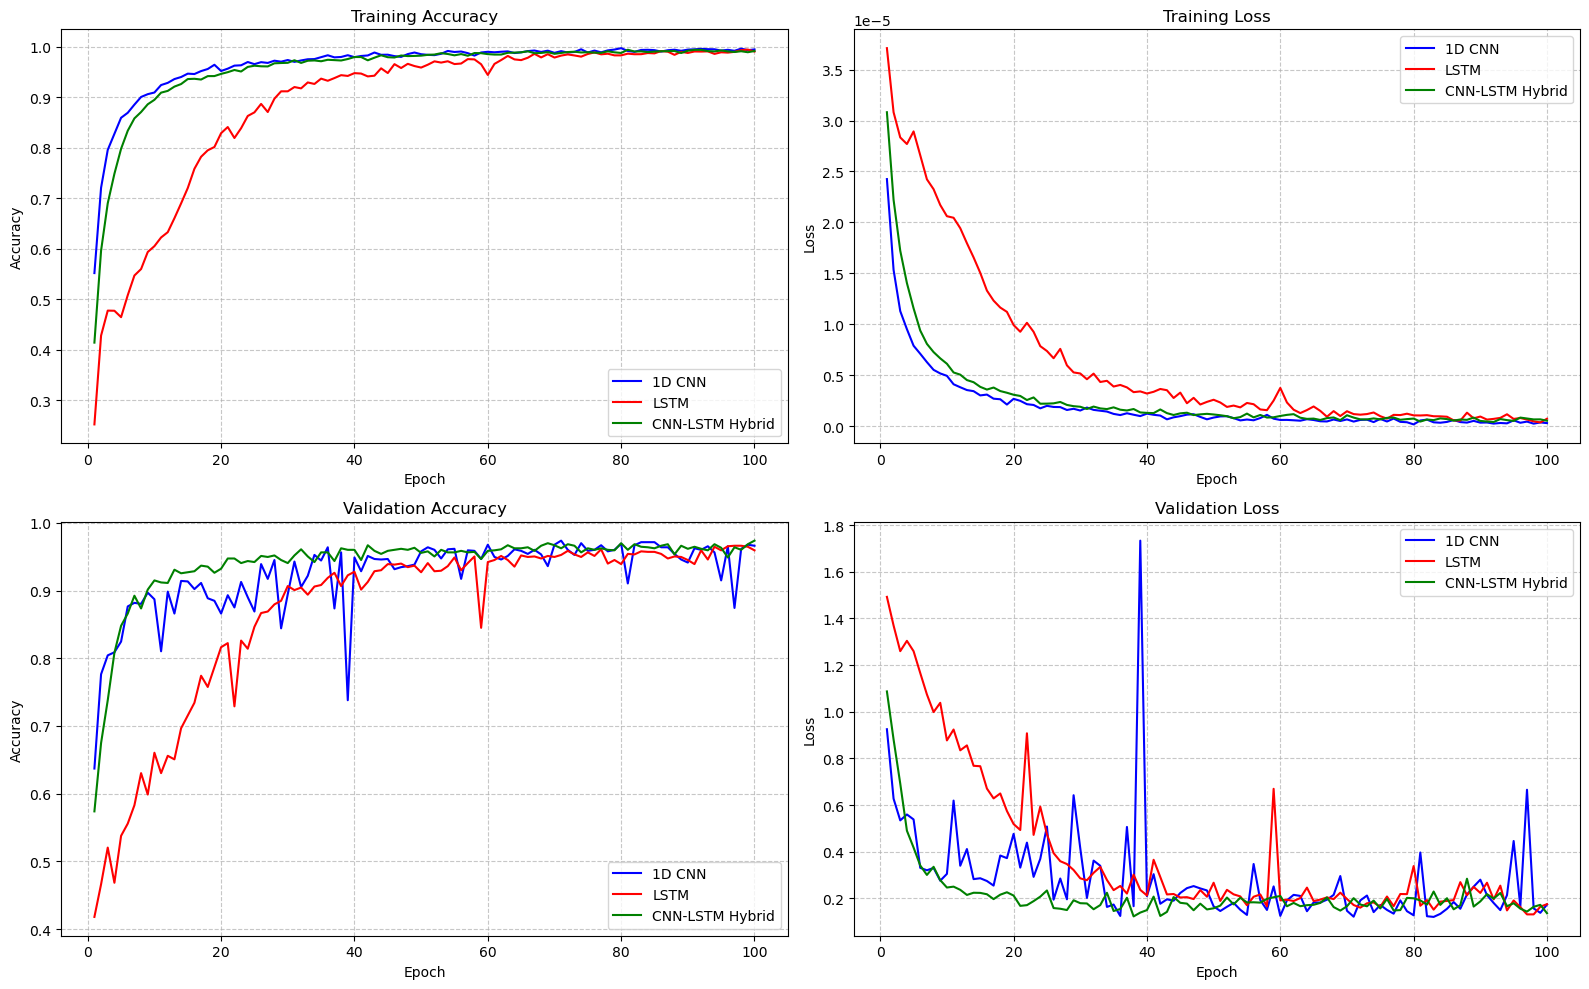

In [34]:
plot_comparison(history_cnn, history_lstm, history_cnn_lstm)